
# NLP Assignment 1


In [ ]:
import os, sys, urllib.request, progressbar, zipfile, string
from tqdm import tqdm
import pandas as pd 
import numpy as np 
from itertools import groupby
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from collections import OrderedDict

import gensim
import gensim.downloader as gloader

import tensorflow
from tensorflow import keras
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Bidirectional, TimeDistributed, Embedding, Dense, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

seed = 42
tensorflow.keras.utils.set_random_seed(seed)

## Datatset download and preparation
Download the dataset 

In [ ]:
pbar = None

def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def download_zip_from_url(url, name, save_path):
 
  if not os.path.exists(save_path):
      os.makedirs(save_path)

  download_path = os.path.join(save_path, name)

  if not os.path.exists(download_path):
      urllib.request.urlretrieve(url, download_path, show_progress)
      print("Successful download")

  with zipfile.ZipFile(download_path,"r") as zip:
      zip.extractall(save_path)
  print("Successful extraction")

In [ ]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zipname = "dataset.zip"

download_zip_from_url(url, zipname, dataset_folder)

100% (457429 of 457429) |################| Elapsed Time: 0:00:00 Time:  0:00:00


Successful download
Successful extraction


Inspect the first document to understand how it's composed

In [ ]:
dataset_name = "dependency_treebank"
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name)
file_path = os.path.join(dataset_folder, 'wsj_0001.dp')

if os.path.isfile(file_path):
    # open the file
    with open(file_path, mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



As you can see, it have 3 columns that refer to the word (idx 0), the tag of the word (idx 1) and a number (idx 3), while it have multiple rows, one fore each word.

## Create the Dataframe
As described in the text we drop the third column

In [ ]:
dataframe_rows = []

print("Creating the dataframe...")
for filename in tqdm(os.listdir(dataset_folder)):
    file_path = os.path.join(dataset_folder, filename)
    f_number = int(filename.split("_")[1].split(".")[0])
    split = "train" if f_number < 101 else ("val" if f_number < 151 else "test")
    try:
        if os.path.isfile(file_path):
            with open(file_path, mode='r', encoding='utf-8') as text_file:
              sent_words = []
              sent_tags = []
              lines = text_file.readlines()
              for line in lines:
                if line == "\n" or line == lines[-1]:
                  if len(sent_words) != 0:
                    dataframe_row = {
                        "file": filename,
                        "sentence": " ".join(sent_words),
                        "labels": " ".join(sent_tags),
                        "split": split
                    }
                    dataframe_rows.append(dataframe_row)

                  sent_words = []
                  sent_tags = []     
                else:
                  line_split = line.split()
                  sent_words.append(line_split[0])
                  sent_tags.append(line_split[1])      
    except Exception as e:
        print('Failed to process %s. Reason: %s' % (file_path, e))
        sys.exit(0)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file", "sentence", "labels", "split"]]

print("\nDone!")
print()
print("Checking correctness length of the dataframe...", end="")
assert 199 == len(df['file'].unique()), "Something is wrong" 
print(" PASS!")
print("Checking absence of empty sentence...", end="")
assert False == any(len(sent) == 0 for sent in df["sentence"]), "Something is wrong" 
print(" PASS!")
print("Checking absence of empty tags sentence...", end="")
assert False == any(len(sent) == 0 for sent in df["labels"]), "Something is wrong" 
print(" PASS!")
print("All good!")

df = df.sort_values("file")
df.reset_index(drop=True, inplace=True)
                       
dataframe_path =  os.path.join(os.getcwd(), "Datasets", "Original", dataset_name + ".pkl")
df.to_pickle(dataframe_path)

Creating the dataframe...


100%|██████████| 199/199 [00:00<00:00, 2561.19it/s]



Done!

Checking correctness length of the dataframe... PASS!
Checking absence of empty sentence... PASS!
Checking absence of empty tags sentence... PASS!
All good!


In [ ]:
df.head()

,file,sentence,labels,split
0,wsj_0001.dp,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",train
1,wsj_0001.dp,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN",train
2,wsj_0002.dp,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",train
3,wsj_0003.dp,The U.S. is one of the few industrialized nati...,DT NNP VBZ CD IN DT JJ VBN NNS WDT VBZ RB VB D...,train
4,wsj_0003.dp,The finding probably will support those who ar...,DT NN RB MD VB DT WP VBP IN DT NNP MD VB DT NN...,train


## Data esploration

In [ ]:
print(f"Total number of sentence: {df.shape[0]}")
print(f"Total number of files: {len(df['file'].unique())}")

Total number of sentence: 3940
Total number of files: 199


In [ ]:
print(f"Dataframe keys: {list(df.keys())}")

Dataframe keys: ['file', 'sentence', 'labels', 'split']


In [ ]:
print("Example of POS tagged sentence:")

pos_tagged_sent = ""
for word, tag in zip(df.loc[0, 'sentence'].split(), df.loc[0, 'labels'].split()):
  pos_tagged_sent += word + " \\" + tag + " "

print(pos_tagged_sent)

Example of POS tagged sentence:
Pierre \NNP Vinken \NNP , \, 61 \CD years \NNS old \JJ , \, will \MD join \VB the \DT board \NN as \IN a \DT nonexecutive \JJ director \NN Nov. \NNP 29 \CD . \. 


In [ ]:
print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of splits: 
train    1974
val      1312
test      654
Name: split, dtype: int64



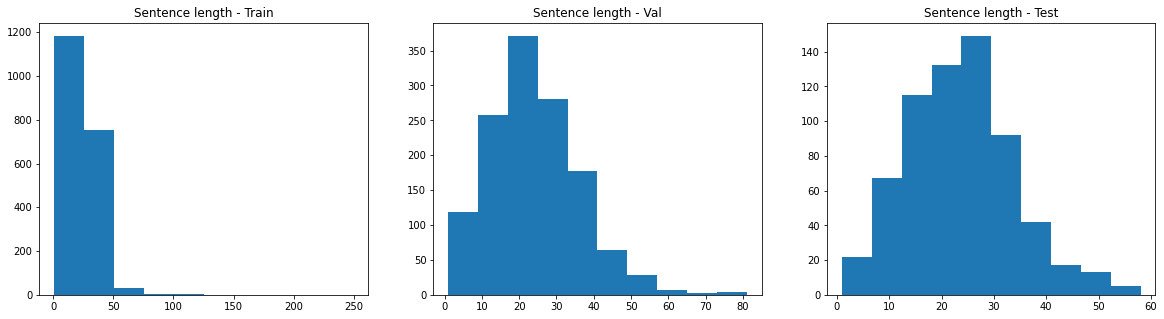

In [ ]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'train'), ['sentence']]["sentence"])))
ax1.set_title("Sentence length - Train")
ax2.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'val'), ['sentence']]["sentence"])))
ax2.set_title("Sentence length - Val")
ax3.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'test'), ['sentence']]["sentence"])))
ax3.set_title("Sentence length - Test")
plt.show()

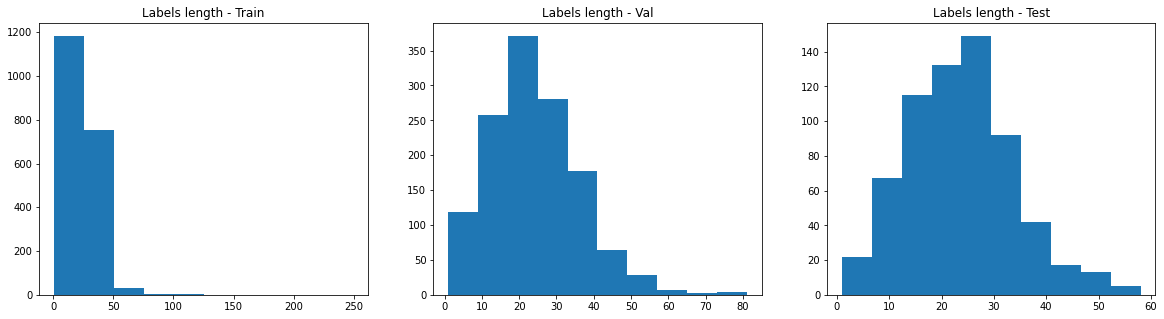

In [ ]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'train'), ['labels']]["labels"])))
ax1.set_title("Labels length - Train")
ax2.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'val'), ['labels']]["labels"])))
ax2.set_title("Labels length - Val")
ax3.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'test'), ['labels']]["labels"])))
ax3.set_title("Labels length - Test")
plt.show()

## Build the vocabulary
Split dataframe in train test and validation

In [ ]:
train = df.loc[df['split'] == "train"]
val = df.loc[df['split'] == "val"]
test = df.loc[df['split'] == "test"]

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"Train shape: {train.shape}")
print(f"  Val shape: {val.shape}")
print(f" Test shape:  {test.shape}")

Train shape: (1974, 4)
  Val shape: (1312, 4)
 Test shape:  (654, 4)


Buid the vocabulary and tokenize inputs

In [ ]:
emb_model = gloader.load("glove-wiki-gigaword-50")
emb_dim = 50

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
word_tokenizer_args = {
    "lower": False,
    "oov_token": "UNK",
    "filters": ""
}

tag_tokenizer_args = {
    "lower": False,
    "filters": ""
}

In [ ]:
class MyTokenizer:

  def __init__(self, tokenizer_args):
    self.tokenizer = Tokenizer(**tokenizer_args)
    self.word_to_idx = {}
    self.idx_to_word = {}
    self.vocab_size = 0
    self.oov_split_terms = [None, None, None]

  def get_oov_terms(self, emb_model, split):
    prev_oov_term = set([oov_term for oov_terms in self.oov_split_terms if oov_terms is not None for oov_term in oov_terms])
    oov = set(self.word_to_idx.keys()).difference(set(emb_model.vocab.keys() | prev_oov_term))
    self.oov_split_terms[split] = oov
    return oov

  def build_vocab(self, data):
    self.tokenizer.fit_on_texts(data)
    self.word_to_idx = self.tokenizer.word_index
    self.idx_to_word = self.tokenizer.index_word
    self.vocab_size =  len(self.word_to_idx)
  
  def texts_to_sequences(self, data):
    return self.tokenizer.texts_to_sequences(data)

Padding and label one-hot encoding

In [ ]:
def create_emb_matrix(word_to_index, emb_dim, oov_terms, verbose=False):
  emb_matrix = np.zeros((len(word_to_index)+1, emb_dim), dtype=np.float32)
  count_lower, count_ngrams, count_rand_emb = [0, 0, 0]

  for word, idx in tqdm(word_to_index.items()):
    if word not in oov_terms:
      emb_vector = emb_model[word]
    else:
      try: # se non trovata, la cerchiamo lower
        emb_vector = emb_model[word.lower()]
        count_lower +=1
      except (KeyError, TypeError):
        try: # se non c'è lower, cerchiamo se è composta del tipo word1-word2
          word_split = word.split("-")
          if len(word_split) >= 2:
            word_emb = []
            for w in word_split:
              word_emb.append(emb_model[w.lower()])
            emb_vector = np.mean(np.array(word_emb), axis=0)
            count_ngrams += 1
          else:
            emb_vector = np.random.uniform(low=-0.05, high=0.05, size=emb_dim)
            count_rand_emb += 1
        except (KeyError, TypeError): # nel caso non sia nessuno dei casi precenti lasciamo l'embedding a 0
          emb_vector = np.random.uniform(low=-0.05, high=0.05, size=emb_dim)
          count_rand_emb += 1

    emb_matrix[idx] = emb_vector

  if verbose:
    print()
    print(f"Total number of OOV terms: {len(oov_terms)}")
    print(f"Number of lower OOV terms: {count_lower}")
    print(f"Number of n-grams OOV terms: {count_ngrams}")
    print(f"Number of random embedding OOV terms: {count_rand_emb}")

  return emb_matrix

### Reduce OOV words


In [ ]:
# V1 (in our assignment )
tokenizer = MyTokenizer(word_tokenizer_args)

# V2 = V1 + OOV1
tokenizer.build_vocab(train.sentence.values)
print('Checking OOV terms...')
train_oov = tokenizer.get_oov_terms(emb_model, split=0) # split 0 means that it's for training 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of train OOV words is: {}'.format(len(train_oov)))
print('Percentage of OOV words w.r.t the Glove vocabulary (V2): {:.1f}%'.format(len(train_oov) / tokenizer.vocab_size * 100)) 
#embedding_matrix = create_emb_matrix(tokenizer.word_to_idx, emb_dim, verbose=True)
print()

# V3
tokenizer.build_vocab(val.sentence.values)
print('Checking OOV terms...')
val_oov = tokenizer.get_oov_terms(emb_model, split=1) # split 1 means that it's for val 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of val OOV words is: {}'.format(len(val_oov)))
print('Percentage of OOV words w.r.t the V2 vocabulary (V3): {:.1f}%'.format(len(val_oov) / tokenizer.vocab_size * 100))
#embedding_matrix = create_emb_matrix(tokenizer.word_to_idx, emb_dim, verbose=True)
print()

# V4
tokenizer.build_vocab(test.sentence.values)
print('Checking OOV terms...')
test_oov = tokenizer.get_oov_terms(emb_model, split=2) # split 2 means that it's for test 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of test OOV words is: {}'.format(len(test_oov)))
print('Percentage of OOV words w.r.t the V3 vocabulary (V4): {:.1f}%'.format(len(test_oov) / tokenizer.vocab_size * 100))
#embedding_matrix = create_emb_matrix(tokenizer.word_to_idx, emb_dim, verbose=True)


Checking OOV terms...
Total number of words is: 8009
Total number of train OOV words is: 2346
Percentage of OOV words w.r.t the Glove vocabulary (V2): 29.3%

Checking OOV terms...
Total number of words is: 10819
Total number of val OOV words is: 944
Percentage of OOV words w.r.t the V2 vocabulary (V3): 8.7%

Checking OOV terms...
Total number of words is: 11968
Total number of test OOV words is: 455
Percentage of OOV words w.r.t the V3 vocabulary (V4): 3.8%


In [ ]:
tot_oov_terms = set(train_oov | val_oov | test_oov)
embedding_matrix = create_emb_matrix(tokenizer.word_to_idx, emb_dim, tot_oov_terms, verbose=True)

100%|██████████| 11968/11968 [00:00<00:00, 207556.91it/s]


Total number of OOV terms: 3745
Number of lower OOV terms: 3059
Number of n-grams OOV terms: 371
Number of random embedding OOV terms: 315


## Train, test and val split

In [ ]:
x_train = train.sentence.values
y_train = train.labels.values

x_val = val.sentence.values
y_val = val.labels.values

x_test = test.sentence.values
y_test = test.labels.values

In [ ]:
print("** Raw word and tags sentence **", "\n", "-"*100, "\n")
print('Sentence: ',x_train[0], '\n')
print('tag: ', y_train[0], '\n')
print()

#word_tokenizer = MyTokenizer(word_tokenizer_args)
#word_tokenizer.build_vocab(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)  
x_test = tokenizer.texts_to_sequences(x_test)  

tag_tokenizer = MyTokenizer(tag_tokenizer_args)
tag_tokenizer.build_vocab(y_train)
y_train = tag_tokenizer.texts_to_sequences(y_train)
y_val = tag_tokenizer.texts_to_sequences(y_val)  
y_test = tag_tokenizer.texts_to_sequences(y_test)  

print("** Tokenized word and tags sentence **", "\n", "-"*100, "\n")
print('Sentence: ',x_train[0], '\n')
print('Tags: ', y_train[0], '\n')
print()

print(f"Word vocabulary size: {tokenizer.vocab_size}")
print(f"Tag vocabulary size: {tag_tokenizer.vocab_size}")

** Raw word and tags sentence ** 
 ---------------------------------------------------------------------------------------------------- 

Sentence:  Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . 

tag:  NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD . 


** Tokenized word and tags sentence ** 
 ---------------------------------------------------------------------------------------------------- 

Sentence:  [5765, 3929, 2, 2072, 81, 429, 2, 38, 2481, 3, 336, 26, 7, 2073, 308, 430, 2074, 4] 

Tags:  [2, 2, 7, 11, 5, 6, 7, 20, 12, 4, 1, 3, 4, 6, 1, 2, 11, 8] 


Word vocabulary size: 11968
Tag vocabulary size: 45


In [ ]:
max_seq_len = int(np.quantile([len(seq) for seq in x_train], 0.99))

x_train = pad_sequences(x_train, maxlen = max_seq_len)
x_val = pad_sequences(x_val, maxlen = max_seq_len)
x_test = pad_sequences(x_test, maxlen = max_seq_len)

y_train = pad_sequences(y_train, maxlen = max_seq_len)
y_val = pad_sequences(y_val, maxlen = max_seq_len)
y_test = pad_sequences(y_test, maxlen = max_seq_len)

y_train = to_categorical(y_train, num_classes=tag_tokenizer.vocab_size+1)
y_val = to_categorical(y_val, num_classes=tag_tokenizer.vocab_size+1)
y_test = to_categorical(y_test, num_classes=tag_tokenizer.vocab_size+1)

## Build the model

In [ ]:
def display_history(history, *args):
  for arg in args:
    train = history.history[arg]
    val = history.history[f"val_{arg}"]

    plt.plot(train)
    plt.plot(val)
    plt.grid()
    plt.title(f"{arg} during training")
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

train_params = {
    'epochs': 80,
    'batch_size': 64,
    'verbose': 1,
    'callbacks': [
    keras.callbacks.EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)]
}

### Model: BiLSTM + TD-Dense

In [ ]:
LSTM_UNITS = 128

lstm_model = Sequential()
lstm_model.add(Embedding(tokenizer.vocab_size+1,
                         emb_dim,
                         weights = [embedding_matrix],
                         input_length=max_seq_len,
                         mask_zero = True,
                         trainable = False))
lstm_model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
lstm_model.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))

lstm_model.compile(loss='categorical_crossentropy',
                   optimizer= keras.optimizers.Adam(),
                   metrics=['categorical_accuracy'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_3 (Bidirectio  (None, 56, 256)          183296    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 56, 46)           11822     
 tributed)                                                       
                                                                 
Total params: 793,568
Trainable params: 195,118
Non-trainable params: 598,450
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), **train_params)

Epoch 1/80
31/31 [==============================] - 29s 626ms/step - loss: 2.9765 - categorical_accuracy: 0.2171 - val_loss: 2.5529 - val_categorical_accuracy: 0.3383
Epoch 2/80
31/31 [==============================] - 18s 600ms/step - loss: 2.2278 - categorical_accuracy: 0.4283 - val_loss: 1.9005 - val_categorical_accuracy: 0.5174
Epoch 3/80
31/31 [==============================] - 21s 687ms/step - loss: 1.6287 - categorical_accuracy: 0.5814 - val_loss: 1.4396 - val_categorical_accuracy: 0.6161
Epoch 4/80
31/31 [==============================] - 24s 789ms/step - loss: 1.2593 - categorical_accuracy: 0.6789 - val_loss: 1.1774 - val_categorical_accuracy: 0.6888
Epoch 5/80
31/31 [==============================] - 20s 647ms/step - loss: 1.0513 - categorical_accuracy: 0.7270 - val_loss: 1.0236 - val_categorical_accuracy: 0.7216
Epoch 6/80
31/31 [==============================] - 21s 688ms/step - loss: 0.9208 - categorical_accuracy: 0.7542 - val_loss: 0.9258 - val_categorical_accuracy: 0.746

In [ ]:
loss, accuracy = lstm_model.evaluate(x_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

21/21 [==============================] - 14s 705ms/step - loss: 0.4202 - categorical_accuracy: 0.8708
Loss: 0.42021870613098145,
Accuracy: 0.8708006739616394


In [ ]:
#lstm_model.save_weights("lstm.h5", overwrite=True, save_format=None, options=None)

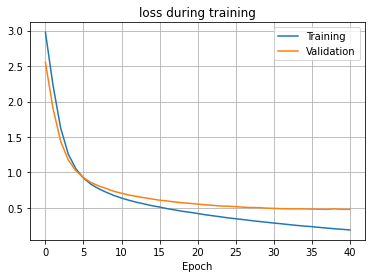

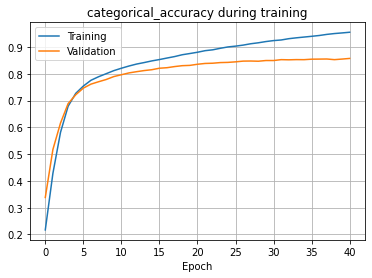

In [ ]:
display_history(lstm_history, "loss", "categorical_accuracy")

### Model: 2xBiLSTM + TD-Dense

In [ ]:
lstm2_model = Sequential()
lstm2_model.add(Embedding(tokenizer.vocab_size+1,
                         emb_dim,
                         weights = [embedding_matrix],
                         input_length=max_seq_len,
                         mask_zero = True,
                         trainable = False))
lstm2_model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
lstm2_model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
lstm2_model.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))

lstm2_model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(),
                   metrics=['categorical_accuracy'])
lstm2_model.summary()

In [ ]:
lstm2_history = lstm2_model.fit(x_train, y_train, validation_data=(x_val, y_val), **train_params)

In [ ]:
display_history(lstm2_history, "loss", "categorical_accuracy")

### Model: Bi-GRU + TD-Dense

In [ ]:
GRU_UNITS= 64 # provare 128

gru_model = Sequential()
gru_model.add(Embedding(tokenizer.vocab_size+1,
                         emb_dim,
                         weights = [embedding_matrix],
                         input_length=max_seq_len,
                         mask_zero = True,
                         trainable = False))
gru_model.add(Bidirectional(GRU(GRU_UNITS, return_sequences=True)))
gru_model.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))

gru_model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(),
                   metrics=['categorical_accuracy'])
gru_model.summary()

In [ ]:
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_val, y_val), **train_params)

In [ ]:
display_history(gru_history, "loss", "categorical_accuracy")

### Model: BiLSTM + 2xTD-Dense

In [ ]:
Dense2_model = Sequential()
Dense2_model.add(Embedding(tokenizer.vocab_size+1,
                         emb_dim,
                         weights = [embedding_matrix],
                         input_length=max_seq_len,
                         mask_zero = True,
                         trainable = False))
Dense2_model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
Dense2_model.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))
Dense2_model.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))

Dense2_model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(0.02),
                   metrics=['categorical_accuracy'])
Dense2_model.summary()

In [ ]:
Dense2_history = Dense2_model.fit(x_train, y_train, validation_data=(x_val, y_val), **train_params)

In [ ]:
display_history(Dense2_history, "loss", "categorical_accuracy")

## Model evaluation

In [ ]:
punct_list = ["SYM", "``", "''", "-LRB-", "-RRB-"] + [punct for punct in string.punctuation]
punct_tag_idxs = [tag_tokenizer.word_to_idx[token] for token in punct_list if token in list(tag_tokenizer.word_to_idx.keys())]
print(f"Puntaction class present in the dataset: {[tag_tokenizer.idx_to_word[idx] for idx in punct_tag_idxs]}")

Puntaction class present in the dataset: ['SYM', '``', "''", '-LRB-', '-RRB-', '#', '$', ',', '.', ':']


In [ ]:
# Utils
def remove_pad(y_true, y_pred):
  y_true_no_pad = []
  y_pred_no_pad = []
  for i in range(len(y_true)):
    if y_true[i] != 0:
      y_true_no_pad.append(y_true[i])    
      y_pred_no_pad.append(y_pred[i]) 
  return y_true_no_pad, y_pred_no_pad

def compute_f1(y_true, y_pred, title):
  f1_value = f1_score(y_true,
            y_pred,
            average='macro',
            labels=[i for i in tag_tokenizer.idx_to_word.keys() if i not in punct_tag_idxs],
            zero_division=0)
  print(f"F1-score on {title}: {f1_value}")

## BiLSTM + TD-Dense





In [ ]:
# prediction on validation and test set
y_pred_val = lstm_model.predict(x_val, batch_size=64)
y_pred_test = lstm_model.predict(x_test, batch_size=64)

11/11 [==============================] - 0s 30ms/step


In [ ]:
# concatenazione delle sentences, riga = token di tutte le sentence,  col = prediction values for each class
y_pred_val = np.reshape(y_pred_val, (y_pred_val.shape[0]*y_pred_val.shape[1], y_pred_val.shape[2]))
y_pred_test = np.reshape(y_pred_test, (y_pred_test.shape[0]*y_pred_test.shape[1], y_pred_test.shape[2]))
print(y_pred_val.shape)
print(y_pred_test.shape)

(73472, 46)
(36624, 46)


In [ ]:
# reshape dei true values per confronto
y_test_true = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], y_test.shape[2]))
y_val_true = np.reshape(y_val, (y_val.shape[0]*y_val.shape[1], y_val.shape[2]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(np.argmax(y_test_true, axis=1),
                               np.argmax(y_pred_test, axis=1),
                               normalize=None,
                               labels=[i for i in tag_tokenizer.idx_to_word.keys()])

df_cfm = pd.DataFrame(conf_matrix,
                      index = [tag for tag in tag_tokenizer.idx_to_word.keys()],
                      columns = [tag for tag in tag_tokenizer.idx_to_word.keys()])

plt.figure(figsize = (30,30))
sns.heatmap(df_cfm, annot=True, annot_kws={"size": 7}, cmap="Blues")
plt.show()

In [ ]:
y_val_true_no_pad, y_pred_val_no_pad = remove_pad(np.argmax(y_val_true, axis=1), np.argmax(y_pred_val, axis=1))

compute_f1(y_val_true_no_pad, y_pred_val_no_pad, "validetion set")

F1-score on validetion set: 0.7037150474352194


In [ ]:
y_test_true_no_pad, y_pred_test_no_pad = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred_test, axis=1))

compute_f1(y_test_true_no_pad, y_pred_test_no_pad, "test set")

F1-score on test set: 0.6787996092186694


In [ ]:
labels = [i for i in tag_tokenizer.idx_to_word.keys() if i not in punct_tag_idxs]
target_names = [tag_tokenizer.idx_to_word[i] for i in labels]

print(classification_report(y_test_true_no_pad, y_pred_test_no_pad, labels = labels, target_names = target_names))

              precision    recall  f1-score   support

          NN       0.81      0.83      0.82      2383
         NNP       0.82      0.88      0.85      1502
          IN       0.95      0.93      0.94      1630
          DT       0.98      0.98      0.98      1335
         NNS       0.80      0.85      0.82       941
          JJ       0.68      0.68      0.68       918
         VBD       0.86      0.84      0.85       634
          RB       0.70      0.71      0.71       381
          CD       0.95      0.95      0.95       858
          VB       0.86      0.91      0.88       403
          CC       0.98      0.98      0.98       366
         VBZ       0.88      0.87      0.88       280
         VBN       0.80      0.59      0.68       366
          TO       1.00      1.00      1.00       386
         PRP       0.95      0.99      0.97       192
         VBG       0.67      0.39      0.50       221
         VBP       0.85      0.79      0.82       134
          MD       0.97    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
test_idx = 186 #@param {type:"slider", min:0, max:654, step:1}
y_true = y_test[test_idx]

y_pred = lstm_model.predict(np.expand_dims(x_test[test_idx], axis=0),
                            batch_size=64, 
                            verbose="0")
y_pred = np.reshape(y_pred, (y_pred.shape[1], y_pred.shape[2]))

# Get true and predicted tag
true_tag_idx = np.argmax(y_true, axis=1)
pred_tag_idx = np.argmax(y_pred, axis=1)

# Remove pagging tag
true_tag_idx_no_pad = [tag_idx for tag_idx in true_tag_idx if tag_idx != 0]
pred_tag_idx_no_pad = pred_tag_idx[(max_seq_len - len(true_tag_idx_no_pad)):]

print()
print(f"TRUE SEQUENCE:\n{' '.join([tag_tokenizer.idx_to_word[idx] for idx in true_tag_idx_no_pad])}")
print("-"*100)
print(f"PREDICTED SEQUENCE:\n{' '.join([tag_tokenizer.idx_to_word[idx] for idx in pred_tag_idx_no_pad])}")

## 2xBiLSTM + TD-Dense


In [ ]:
# prediction on validation and test set
y_pred_val2 = lstm2_model.predict(x_val, batch_size=64)
y_pred_test2 = lstm2_model.predict(x_test, batch_size=64)

In [ ]:
# concatenazione delle sentences, riga = token di tutte le sentence,  col = prediction values for each class
y_pred_val2 = np.reshape(y_pred_val2, (y_pred_val2.shape[0]*y_pred_val2.shape[1], y_pred_val2.shape[2]))
y_pred_test2 = np.reshape(y_pred_test2, (y_pred_test2.shape[0]*y_pred_test2.shape[1], y_pred_test2.shape[2]))
print(y_pred_val2.shape)
print(y_pred_test2.shape)

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_true, axis=1),
                               np.argmax(y_pred_test2, axis=1),
                               normalize=None,
                               labels=[i for i in tag_tokenizer.idx_to_word.keys()])

df_cfm = pd.DataFrame(conf_matrix,
                      index = [tag for tag in tag_tokenizer.idx_to_word.keys()],
                      columns = [tag for tag in tag_tokenizer.idx_to_word.keys()])

plt.figure(figsize = (30,30))
sns.heatmap(df_cfm, annot=True, annot_kws={"size": 7}, cmap="Blues")
plt.show()

In [ ]:
y_val_true_no_pad, y_pred_val_no_pad = remove_pad(np.argmax(y_val_true, axis=1), np.argmax(y_pred_val2, axis=1))
compute_f1(y_val_true_no_pad, y_pred_val_no_pad, "validetion set")

print("")

y_test_true_no_pad, y_pred_test_no_pad = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred_test2, axis=1))
compute_f1(y_test_true_no_pad, y_pred_test_no_pad, "test set")

In [ ]:
print(classification_report(y_test_true_no_pad, y_pred_test_no_pad, labels = labels, target_names = target_names))

f1 biGRU

In [ ]:
y_pred_val = gru_model.predict(x_val, batch_size=64)
y_pred_test = gru_model.predict(x_test, batch_size=64)

y_pred_val = np.reshape(y_pred_val, (y_pred_val.shape[0]*y_pred_val.shape[1], y_pred_val.shape[2]))
y_pred_test = np.reshape(y_pred_test, (y_pred_test.shape[0]*y_pred_test.shape[1], y_pred_test.shape[2]))


y_test_true_no_pad, y_pred_test_no_pad = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred_test, axis=1))
compute_f1(y_test_true_no_pad, y_pred_test_no_pad, "test set")